In [1]:
# from euler_speedup_new import grid_search
from euler_gpu.preprocess import initialize, max_intensity_projection_and_downsample
from euler_gpu.transform import transform_image, transform_image_3d, transform_image_3d_v0, translate_along_z
from euler_gpu.grid_search import grid_search

from util import get_image_T, get_cropped_image, get_image_CM, locate_directory, calculate_gncc
# from euler_search import build_transform_matrix
# from pair_ch1_ch2 import transform
from tqdm import tqdm
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import json

In [2]:
torch.cuda.device_count()

4

In [3]:
z_dim = 56
X_RANGE = np.linspace(-1.0, 1.0, 100, dtype=np.float32)
Y_RANGE = np.linspace(-1.0, 1.0, 100, dtype=np.float32)
THETA_RANGE = np.linspace(0, 360, 360, dtype=np.float32)
BATCH_SIZE = 200
DEVICE = torch.device("cuda:1")

memory_dict = initialize(
             np.zeros((208, 96)).astype(np.float32),
             np.zeros((208, 96)).astype(np.float32),
             torch.zeros(z_dim, device=DEVICE),
             torch.zeros(z_dim, device=DEVICE),
             torch.zeros(z_dim, device=DEVICE),
             z_dim,
             DEVICE)

memory_dict_for_grid_search = initialize(
                         np.zeros((208, 96)).astype(np.float32),
                         np.zeros((208, 96)).astype(np.float32),
                         X_RANGE,
                         Y_RANGE,
                         THETA_RANGE,
                         BATCH_SIZE,
                         DEVICE
                        )

In [4]:
def filter_image(image, threshold):
    filtered_image = image - threshold
    filtered_image[filtered_image < 0] = 0

    return filtered_image

### manually check *bad* euler-gpu transformed moving images

In [5]:
# all_files = os.listdir('/home/alicia/data_personal/registered/euler_grid_search_full-v1')
# ds_name_problems = [file.split('.')[0] for file in all_files if 'json' not in file]

ds_name_problem = '2022-07-15-06_963to1361'
# ds_name_problem = '2022-01-09-01_633to791'
ds_name, problem = ds_name_problem.split('_')
ds_path = locate_directory(ds_name)

# prepare input image pairs
t_moving, t_fixed = problem.split('to')
t_moving_4 = t_moving.zfill(4)
t_fixed_4 = t_fixed.zfill(4)

fixed_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
)[0]

moving_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
)[0]

fixed_image_T = get_image_T(fixed_image_path)
moving_image_T = get_image_T(moving_image_path)

# filter image
moving_image_median = np.median(moving_image_T)
print(moving_image_median)
moving_image_T = filter_image(moving_image_T, moving_image_median)
fixed_image_T = filter_image(fixed_image_T, moving_image_median)

# crop image
fixed_image_CM = get_image_CM(fixed_image_T)
moving_image_CM = get_image_CM(moving_image_T)
resized_fixed_image_xy = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, 2).astype(np.float32)
resized_moving_image_xy = get_cropped_image(
                moving_image_T,
                moving_image_CM, 2).astype(np.float32)
resized_fixed_image_xyz = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, -1).astype(np.float32)
resized_moving_image_xyz = get_cropped_image(
                moving_image_T,
                moving_image_CM, -1).astype(np.float32)

# downsampling
downsample_factor = 1
downsampled_resized_fixed_image_xy = max_intensity_projection_and_downsample(
                                        resized_fixed_image_xyz,
                                        downsample_factor).astype(np.float32)
downsampled_resized_moving_image_xy = max_intensity_projection_and_downsample(
                                        resized_moving_image_xyz,
                                        downsample_factor).astype(np.float32)


# update memory_dict
memory_dict_for_grid_search["fixed_images_repeated"] = torch.tensor(
            downsampled_resized_fixed_image_xy,
            device=DEVICE,
            dtype=torch.float32).unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1)

memory_dict_for_grid_search["moving_images_repeated"] = torch.tensor(
            downsampled_resized_moving_image_xy,
            device=DEVICE,
            dtype=torch.float32).unsqueeze(0).repeat(BATCH_SIZE, 1, 1, 1)

best_score, best_transformation = grid_search(memory_dict_for_grid_search)
dx_gpu, dy_gpu, angles_rad = best_transformation

# transform image 3D
transformed_moving_image_xyz = transform_image_3d(
                resized_moving_image_xyz,
                memory_dict,
                best_transformation,
                DEVICE)

print(transformed_moving_image_xyz.shape)

210.0
(208, 96, 56)


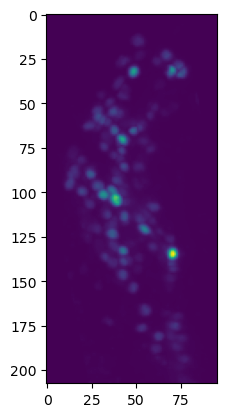

In [6]:
plt.imshow(transformed_moving_image_xyz.max(2));

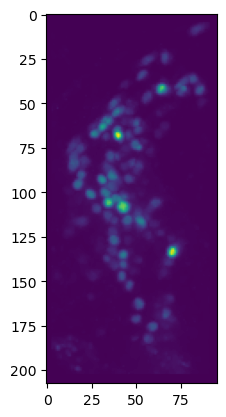

In [7]:
plt.imshow(resized_fixed_image_xyz.max(2));

In [8]:
best_transformation

(tensor([-0.1313], device='cuda:1'),
 tensor([-0.0303], device='cuda:1'),
 tensor([0.1925], device='cuda:1'))

In [9]:
shift_range = range(-50, 50)
dz, gncc, final_moving_image_xyz = translate_along_z(
    shift_range, resized_fixed_image_xyz, transformed_moving_image_xyz, moving_image_median)

In [10]:
dz, gncc

(1, 0.508898631030626)

In [11]:
np.unique(final_moving_image_xyz)

array([0.00000000e+00, 1.94936001e-06, 3.00211832e-06, ...,
       2.35902759e+03, 2.40364185e+03, 2.46264844e+03])

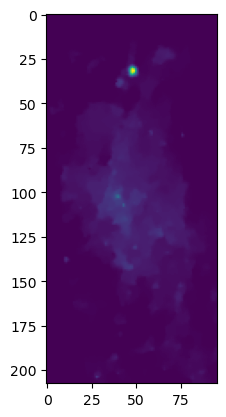

In [12]:
plt.imshow(transformed_moving_image_xyz[:, :, 3]);

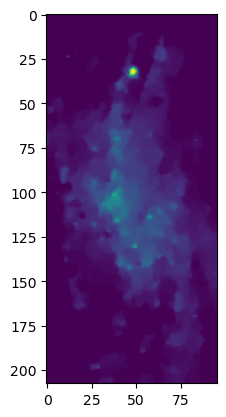

In [13]:
plt.imshow(final_moving_image_xyz[:, :, 3]);

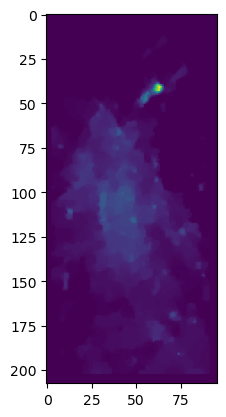

In [14]:
plt.imshow(resized_fixed_image_xyz[:, :, 3]);

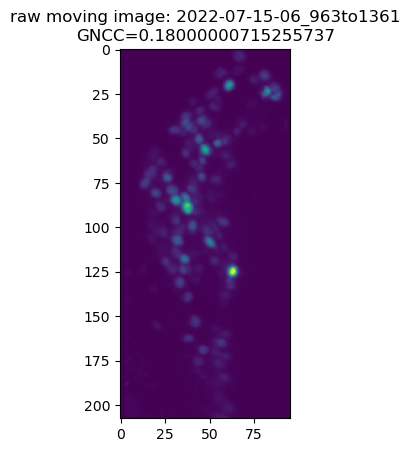

In [15]:
raw_gncc = round(calculate_gncc(resized_fixed_image_xyz, resized_moving_image_xyz), 2)
plt.imshow(resized_moving_image_xy);
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.title(f'raw moving image: {ds_name_problem}\nGNCC={raw_gncc}');

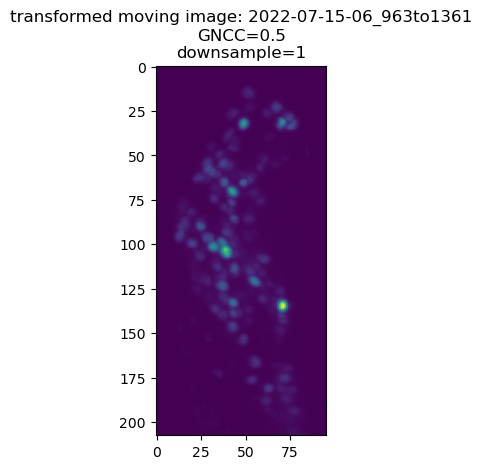

In [17]:
transformed_gncc = calculate_gncc(resized_fixed_image_xyz, transformed_moving_image_xyz)
plt.imshow(transformed_moving_image_xyz.max(2));
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1));
plt.title(f'transformed moving image: {ds_name_problem}\nGNCC={round(transformed_gncc, 2)}\ndownsample={downsample_factor}');

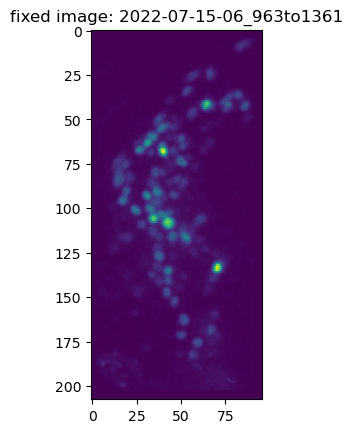

In [18]:
plt.imshow(resized_fixed_image_xy);
plt.title(f'fixed image: {ds_name_problem}');

In [19]:
np.amax(resized_fixed_image_xy), np.amax(transformed_moving_image_xyz.max(2))

(1512.0, 2462.6484)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


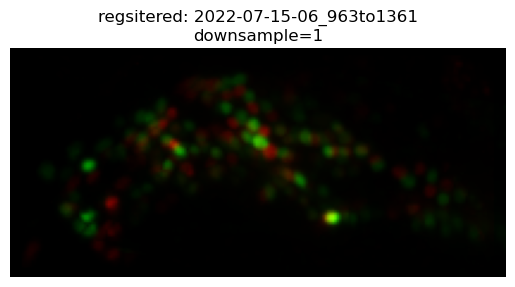

In [20]:
axis = 2
imc1 = resized_fixed_image_xy
imc2 = transformed_moving_image_xyz.max(2)
imc3 = np.zeros(imc1.shape)
vmax = int(max(np.amax(resized_fixed_image_xy), np.amax(transformed_moving_image_xyz.max(2))))
plt.title(f"regsitered: {ds_name_problem}\ndownsample={downsample_factor}");
plt.imshow(np.swapaxes(np.stack((imc1/vmax, imc2/vmax, imc3)), 2, 0));
plt.axis("off");

### using euler_speedup_new

In [86]:
all_files = os.listdir('/home/alicia/data_personal/registered/euler_grid_search_full-v1')
ds_name_problems = [file.split('.')[0] for file in all_files if 'json' not in file]

X_RANGE = np.linspace(-1.0, 1.0, 200, dtype=np.float32)
Y_RANGE = np.linspace(-1.0, 1.0, 200, dtype=np.float32)
THETA_RANGE = np.linspace(0, 360, 360, dtype=np.float32)
BATCH_SIZE = 200
DEVICE = 'cuda:0'

euler_gpu_gnccs = dict()

for ds_name_problem in tqdm(ds_name_problems):
    ds_name, problem = ds_name_problem.split('_')
    ds_path = locate_directory(ds_name)
    
    # prepare input image pairs
    t_moving, t_fixed = problem.split('to')
    t_moving_4 = t_moving.zfill(4)
    t_fixed_4 = t_fixed.zfill(4)

    fixed_image_path = glob.glob(
        f'{ds_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
    )[0]

    moving_image_path = glob.glob(
        f'{ds_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
    )[0]
    fixed_image_T = get_image_T(fixed_image_path)
    moving_image_T = get_image_T(moving_image_path)
    fixed_image_CM = get_image_CM(fixed_image_T)
    moving_image_CM = get_image_CM(moving_image_T)
    resized_fixed_image_xy = get_cropped_image(
                    fixed_image_T,
                    fixed_image_CM, 2)
    resized_moving_image_xy = get_cropped_image(
                    moving_image_T,
                    moving_image_CM, 2)
    resized_fixed_image_xyz = get_cropped_image(
                    fixed_image_T,
                    fixed_image_CM, -1)
    resized_moving_image_xyz = get_cropped_image(
                    moving_image_T,
                    moving_image_CM, -1)

    resized_fixed_image_xy = resized_fixed_image_xy.astype(np.float32)
    resized_moving_image_xy = resized_moving_image_xy.astype(np.float32)

    memory_dict = initialize(resized_fixed_image_xy,
                             resized_moving_image_xy,
                             X_RANGE,
                             Y_RANGE,
                             THETA_RANGE,
                             BATCH_SIZE,
                             DEVICE
                            )
    best_score, best_transformation = grid_search(memory_dict)
    dx_gpu, dy_gpu, angles_rad = best_transformation

    transformed_moving_image = transform_image(
                                memory_dict["moving_images_repeated"],
                                dx_gpu,
                                dy_gpu,
                                angles_rad,
                                memory_dict
                            )
    transformed_moving_image_xy = transformed_moving_image.squeeze(0,1).cpu().numpy()

    gncc = calculate_gncc(resized_fixed_image_xy, transformed_moving_image_xy)
    euler_gpu_gnccs[ds_name_problem] = gncc

  2%|█▍                                                                                        | 3/181 [10:35<10:28:22, 211.81s/it]


KeyboardInterrupt: 

In [6]:
euler_gpu_gnccs

{'2022-07-15-06_963to1361': 0.52558523,
 '2022-01-27-04_865to1132': 0.83067113,
 '2022-07-15-06_94to241': 0.59320515,
 '2022-07-26-01_473to1456': 0.8104604,
 '2022-06-14-01_873to1421': 0.62031054,
 '2022-02-16-04_1022to1437': 0.47540697,
 '2022-07-26-01_76to78': 0.5262071,
 '2022-03-22-01_248to1333': 0.4851656,
 '2022-03-22-01_295to475': 0.5064055,
 '2022-06-14-01_430to1199': 0.7196628,
 '2022-01-27-04_227to722': 0.44666222,
 '2022-04-14-04_103to764': 0.497956,
 '2022-01-23-04_379to864': 0.70586747,
 '2022-08-02-01_32to386': 0.52560294,
 '2022-04-05-01_1348to1357': 0.69309574,
 '2022-04-12-04_378to1376': 0.45304412,
 '2022-06-14-01_910to1206': 0.4887112,
 '2022-06-14-01_897to1452': 0.45435816,
 '2022-04-05-01_191to561': 0.44232342,
 '2022-04-12-04_371to450': 0.5133662,
 '2022-01-27-01_78to727': 0.6567044,
 '2022-04-14-04_1305to1325': 0.61819327,
 '2022-01-27-04_970to1306': 0.7417389,
 '2022-04-18-04_669to1251': 0.57766575,
 '2022-04-18-04_891to1515': 0.5234287,
 '2022-01-27-01_119to536

In [40]:
bad_euler_gpu_ds_names = [ds_name_problem for ds_name_problem, gncc in euler_gpu_gnccs.items() if gncc < 0.5]
bad_euler_gpu_gnccs = [euler_gpu_gnccs[ds_name] for ds_name in bad_euler_gpu_ds_names]
bad_euler_gpu_instances = list(zip(bad_euler_gpu_ds_names, bad_euler_gpu_gnccs))

In [41]:
bad_euler_gpu_instances

[('2022-02-16-04_1022to1437', 0.47540697),
 ('2022-03-22-01_248to1333', 0.4851656),
 ('2022-01-27-04_227to722', 0.44666222),
 ('2022-04-14-04_103to764', 0.497956),
 ('2022-04-12-04_378to1376', 0.45304412),
 ('2022-06-14-01_910to1206', 0.4887112),
 ('2022-06-14-01_897to1452', 0.45435816),
 ('2022-04-05-01_191to561', 0.44232342),
 ('2022-07-15-06_832to1199', 0.47474357),
 ('2022-01-17-01_698to1546', 0.49407807),
 ('2022-07-15-06_1523to1599', 0.49162585),
 ('2022-04-14-04_340to1023', 0.49487877),
 ('2022-03-22-01_418to800', 0.45434907),
 ('2022-01-09-01_134to202', 0.42680943),
 ('2022-06-28-01_122to586', 0.4971847),
 ('2022-07-20-01_404to1343', 0.48840523),
 ('2022-01-09-01_333to465', 0.4352454),
 ('2022-04-18-04_544to668', 0.4821682),
 ('2022-07-26-01_525to1560', 0.44515872),
 ('2022-01-17-01_899to1097', 0.48777676),
 ('2022-02-16-04_70to126', 0.43726853),
 ('2022-07-26-01_29to112', 0.44521677),
 ('2022-03-22-01_293to580', 0.46807092),
 ('2022-01-09-01_166to638', 0.47971547),
 ('2022-04-

In [42]:
ds_name_problem, gncc = bad_euler_gpu_instances[0]
ds_name, problem = ds_name_problem.split('_')
ds_path = locate_directory(ds_name)

# prepare input image pairs
t_moving, t_fixed = problem.split('to')
t_moving_4 = t_moving.zfill(4)
t_fixed_4 = t_fixed.zfill(4)

fixed_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
)[0]

moving_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
)[0]
fixed_image_T = get_image_T(fixed_image_path)
moving_image_T = get_image_T(moving_image_path)
fixed_image_CM = get_image_CM(fixed_image_T)
moving_image_CM = get_image_CM(moving_image_T)
resized_fixed_image_xy = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, 2)
resized_moving_image_xy = get_cropped_image(
                moving_image_T,
                moving_image_CM, 2)
resized_fixed_image_xyz = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, -1)
resized_moving_image_xyz = get_cropped_image(
                moving_image_T,
                moving_image_CM, -1)

resized_fixed_image_xy = resized_fixed_image_xy.astype(np.float32)
resized_moving_image_xy = resized_moving_image_xy.astype(np.float32)

best_score, best_transformation, transformed_moving_image = grid_search(
            resized_fixed_image_xy,
            resized_moving_image_xy,
            X_RANGE,
            Y_RANGE,
            THETA_RANGE,
            200,
            device='cuda:0')

In [1]:
# dx_gpu, dy_gpu, angles_rad = best_transformation
# dx_gpu, dy_gpu, angles_rad 

In [ ]:
transform_image(images_repeated, dx_gpu, dy_gpu, angles_rad, memory_dict)

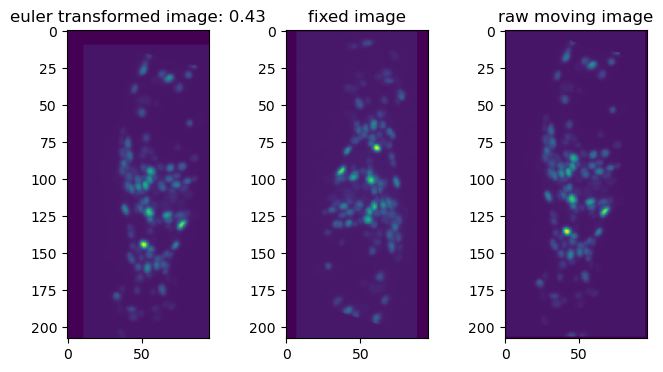

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

axes[0].imshow(transformed_moving_image);
axes[0].set_title(f'euler transformed image: {round(best_score.item(),2)}');
axes[1].imshow(resized_fixed_image_xy);
axes[1].set_title('fixed image');
axes[2].imshow(resized_moving_image_xy);
axes[2].set_title('raw moving image');

In [8]:
def json_serializable(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    raise TypeError(f"Object of type '{obj.__class__.__name__}' is not JSON serializable")
    
with open('/home/alicia/data_personal/registered/euler_grid_search_full-gpu/euler_search_gpu_gncc.json', 'w') as f:
    json.dump(euler_gpu_gnccs, f, indent=4, default=json_serializable)

In [22]:
with open('/home/alicia/data_personal/registered/euler_grid_search_full-v1/euler_search_gncc.json', 'r') as f:
    euler_cpu_gnccs = json.load(f)

with open('/home/alicia/data_personal/registered/euler_grid_search_full-v1/elastix_euler_gncc.json', 'r') as f:
    euler_elastix_gnccs = json.load(f)

In [13]:
euler_cpu_gnccs

{'2022-07-15-06_963to1361': 0.5346667661227106,
 '2022-01-27-04_865to1132': 0.6661199225961323,
 '2022-07-15-06_94to241': 0.6153243496504051,
 '2022-07-26-01_473to1456': 0.5785838948013703,
 '2022-06-14-01_873to1421': 0.4244735056444278,
 '2022-02-16-04_1022to1437': 0.8256841851582809,
 '2022-07-26-01_76to78': 0.4527684979392583,
 '2022-03-22-01_248to1333': 0.8062582904882547,
 '2022-03-22-01_295to475': 0.7727193010042709,
 '2022-06-14-01_430to1199': 0.7070538830542785,
 '2022-01-27-04_227to722': 0.7040849177151625,
 '2022-04-14-04_103to764': 0.7269751196807074,
 '2022-01-23-04_379to864': 0.5311372101415651,
 '2022-08-02-01_32to386': 0.5789138702840714,
 '2022-04-05-01_1348to1357': 0.662775379390251,
 '2022-04-12-04_378to1376': 0.7895148991202692,
 '2022-06-14-01_910to1206': 0.6721738497657336,
 '2022-06-14-01_897to1452': 0.48802359678251783,
 '2022-04-05-01_191to561': 0.7168441689595801,
 '2022-04-12-04_371to450': 0.6358553122005343,
 '2022-01-27-01_78to727': 0.44878726685524434,
 '20

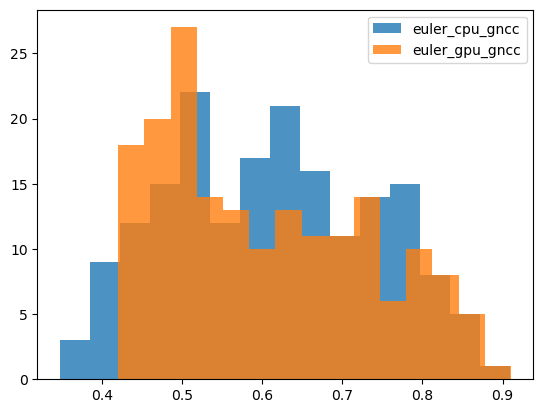

In [16]:
plt.hist(euler_cpu_gnccs.values(), alpha=0.8, label='euler_cpu_gncc', bins=15)
plt.hist(euler_gpu_gnccs.values(), alpha=0.8, label='euler_gpu_gncc', bins=15)
plt.legend();

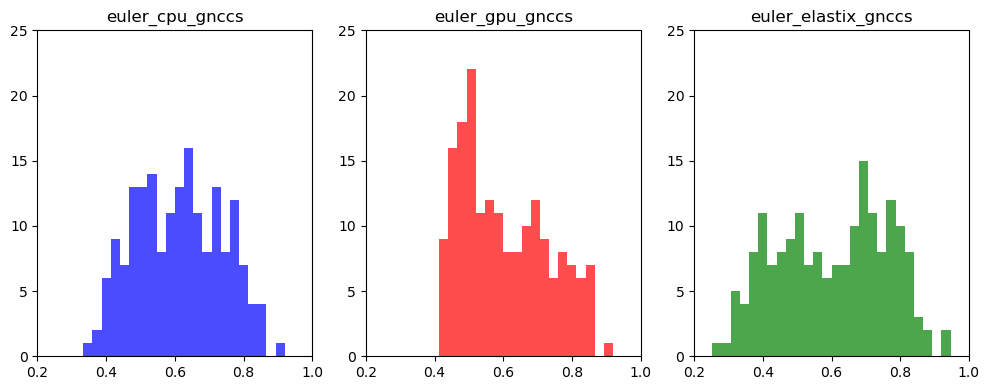

In [31]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot histograms
bin_edges = np.linspace(0.2, 1, 31)

axes[0].hist(euler_cpu_gnccs.values(), bins=bin_edges, color='blue', alpha=0.7)
axes[0].set_title('euler_cpu_gnccs (searched+)')
axes[0].set_ylim([0, 25])
axes[0].set_xlim([0.2, 1])

axes[1].hist(euler_gpu_gnccs.values(), bins=bin_edges, color='red', alpha=0.7)
axes[1].set_title('euler_gpu_gnccs')
axes[1].set_ylim([0, 25])
axes[1].set_xlim([0.2, 1])

axes[2].hist(euler_elastix_gnccs.values(), bins=bin_edges, color='green', alpha=0.7)
axes[2].set_title('euler_elastix_gnccs')
axes[2].set_ylim([0, 25])
axes[2].set_xlim([0.2, 1])

plt.tight_layout() 
plt.show()

In [3]:
ds_name = '2022-01-09-01'
problem = '102to675'
ds_path = locate_directory(ds_name)
print(f'dspath: {ds_path}')

# read in the searched optimal values
grid = np.load(f'/home/alicia/data_personal/registered/euler_grid_search_full-v1/{ds_name}_{problem}.npy')
max_gncc = np.nanmax(grid)
dx, dy, dtheta = np.unravel_index(np.nanargmax(grid), grid.shape)
print(f'searched gncc: {max_gncc}')
print(f'searched dx: {dx}')
print(f'searched dy: {dy}')
print(f'searched dtheta: {dtheta}')

# prepare input image pairs
t_moving, t_fixed = problem.split('to')
t_moving_4 = t_moving.zfill(4)
t_fixed_4 = t_fixed.zfill(4)

fixed_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_fixed_4}_ch2.nrrd'
)[0]

moving_image_path = glob.glob(
    f'{ds_path}/NRRD_filtered/*_t{t_moving_4}_ch2.nrrd'
)[0]
fixed_image_T = get_image_T(fixed_image_path)
moving_image_T = get_image_T(moving_image_path)
fixed_image_CM = get_image_CM(fixed_image_T)
moving_image_CM = get_image_CM(moving_image_T)
resized_fixed_image_xy = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, 2)
resized_moving_image_xy = get_cropped_image(
                moving_image_T,
                moving_image_CM, 2)
resized_fixed_image_xyz = get_cropped_image(
                fixed_image_T,
                fixed_image_CM, -1)
resized_moving_image_xyz = get_cropped_image(
                moving_image_T,
                moving_image_CM, -1)

dspath: /home/alicia/data_prj_kfc/data_processed/2022-01-09-01_output
searched gncc: 0.6630580476757718
searched dx: 3
searched dy: 0
searched dtheta: 0


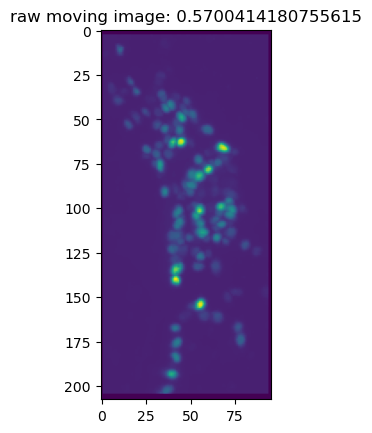

In [32]:
gncc = calculate_gncc(resized_moving_image_xyz, resized_fixed_image_xyz)
plt.title(f'raw moving image: {gncc}')
plt.imshow(resized_moving_image_xy);

In [36]:
### apply Euler transformation
rt_matrix = build_transform_matrix(resized_moving_image_xy.shape, dx, dy, dtheta, order='r')
tr_matrix = build_transform_matrix(resized_moving_image_xy.shape, dx, dy, dtheta, order='t')

rt_transformed_moving_image = transform(rt_matrix, resized_moving_image_xyz)
tr_transformed_moving_image = transform(tr_matrix, resized_moving_image_xyz)

Text(0.5, 1.0, 'rt transformed: 0.6478997468948364')

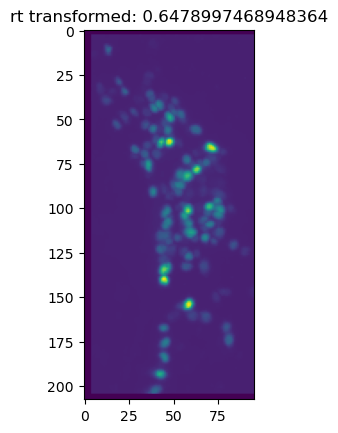

In [38]:
rt_gncc = calculate_gncc(rt_transformed_moving_image, resized_fixed_image_xyz)
plt.imshow(rt_transformed_moving_image.max(2));
plt.title(f'rt transformed: {rt_gncc}')

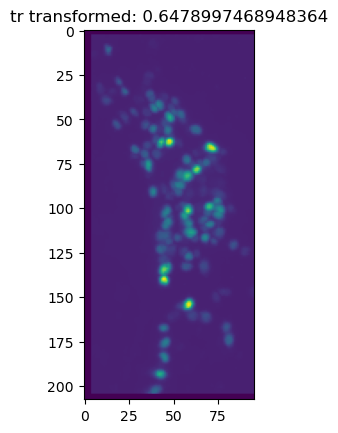

In [40]:
tr_gncc = calculate_gncc(tr_transformed_moving_image, resized_fixed_image_xyz)
plt.imshow(tr_transformed_moving_image.max(2));
plt.title(f'tr transformed: {tr_gncc}');

In [21]:
X_RANGE = np.linspace(-0.5, 0.5, 100, dtype=np.float32)
Y_RANGE = np.linspace(-1.0, 1.0, 100, dtype=np.float32)
THETA_RANGE = (0, 360)

resized_fixed_image_xyz = resized_fixed_image_xyz.astype(np.float32)
resized_moving_image_xyz = resized_moving_image_xyz.astype(np.float32)

resized_fixed_image_xy = resized_fixed_image_xy.astype(np.float32)
resized_moving_image_xy = resized_moving_image_xy.astype(np.float32)

best_score, best_transformation, transformed_moving_image = grid_search(
            resized_fixed_image_xy,
            resized_moving_image_xy,
            X_RANGE,
            Y_RANGE,
            THETA_RANGE,
            200,
            device='cuda:0')

rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 208, 96])
rotation_matrices shape: torch.Size([200, 2, 3])
images_repeated.size: torch.Size([200, 1, 

rotation_matrices shape: torch.Size([1, 2, 3])
images_repeated.size: torch.Size([1, 1, 208, 96])


In [24]:
print(f'best_score: {best_score}')
print(f'best_transformation: {best_transformation}')

best_score: 0.72133868932724
best_transformation: (tensor([0.0152], device='cuda:0'), tensor([-0.0707], device='cuda:0'), tensor([0.], device='cuda:0'))


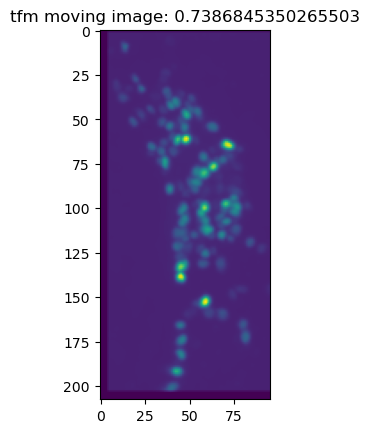

In [30]:
gncc = calculate_gncc(resized_fixed_image_xy, transformed_moving_image)
plt.imshow(transformed_moving_image);
plt.title(f'tfm moving image: {gncc}');

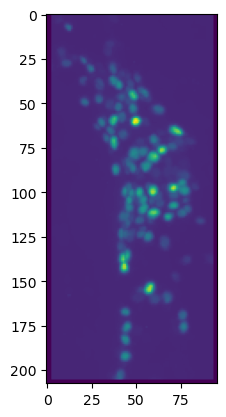

In [31]:
plt.imshow(resized_fixed_image_xy);